Import frames and train, test, evaluate network on flows images

# Importing Dependencies

In [1]:
# from break_loop import BreakLoopException
from display import pltDisplay
from pathlib import Path
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
# from sklearn.model_selection import ParameterSampler
from sorting import human_sort
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
# from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, Concatenate
from tensorflow.keras.models import Model
# from timeit import default_timer

# from pyflow import pyflow

# import IPython.display as ipd
import constants as const
import csv
import cv2
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import progressbar as pb
import random
import seaborn as sns
import tensorflow as tf
# import tensorflow.keras.backend as K
import time
import utils
# import utils_flow as ut_fl

In [137]:
# Set mlflow parameters

In [138]:
# Online -   https://www.mlflow.org/docs/latest/getting-started/tracking-server-overview/index.html method 2
# Host: https://community.cloud.databricks.com/
mlflow.login()
mlflow.set_tracking_uri(uri="databricks")

2024/06/09 20:03:30 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [169]:
mlflow.tensorflow.autolog(
    log_input_examples=False,
    log_model_signatures=False,
    log_models=False,
    log_datasets=False,
)

In [ ]:
mlflow.set_experiment("/Flows")

In [140]:
def clear_gpu():
    gc.collect()

In [2]:
utils.system_info()


    Windows:
        Version: 10.0 build 19045
    Python:
        Version: 3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
        Path: C:\Users\mic-c\anaconda3\envs\opencv_contrib_env\python.exe
    


In [3]:
utils.modules_info()


    OpenCV:
        Version: 4.9.0
    Tensorflow:
        Version: 2.10.1
    


In [4]:
# Set the seed value for experiment reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

In [5]:
log_file = Path(const.logs_path, 'FLOWER.log')
logging.basicConfig(
    format='%(asctime)s %(message)s',
    filemode='a',
    filename=log_file,
    encoding='utf-8',
    level=logging.INFO,
    force=True
)

# Importing Dataset

In [6]:
df = pd.read_csv(Path(const.csv_path, 'dataset.csv'))

In [ ]:
IMG_WIDTH = IMG_HEIGHT = 64
IMG_CHANNELS = 1
SEED = 42
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
EMOTIONS_LABELS = const.EMOTIONS_LABELS

In [9]:
label_names = const.EMOTIONS_LABELS_SORTED.copy()
label_names = ['happy', 'sad']

label_names_gender = []
for em in label_names:
    label_names_gender.append(em + '_female')
    label_names_gender.append(em + '_male')

## Dataset Creation for ML

In [9]:
dataset_path = Path(const.flows_path, 'TVL1/')
TOTAL_ELEMENTS = 156822

#### Dataset Creation - OLD

In [15]:
# https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
def get_dataset_partitions_tf(ds, ds_size, filenames, train_split=0.8,
                              val_split=0.1, test_split=0.1,
                              shuffle=True, shuffle_size=1000):

    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=SEED)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    train_files = filenames[:train_size]

    val_ds = ds.skip(train_size).take(val_size)
    val_files = filenames[train_size:(train_size + val_size)]

    test_ds = ds.skip(train_size).skip(val_size)
    test_files = filenames[(train_size + val_size): ds_size]

    return train_ds, val_ds, test_ds, train_files, val_files, test_files

In [20]:
# Percentuale dataset iniziale usato
f'{(len(ds) / TOTAL_ELEMENTS):.2%}'

'65.48%'

In [21]:
# reduced_ds = ds.take(10000)
reduced_ds = ds
# Use reduced dataset
(train_ds, val_ds, test_ds,
 train_files, val_files, test_files) = get_dataset_partitions_tf(
    reduced_ds, len(reduced_ds), filenames, shuffle=False)

#### Dataset Creation - NEW

In [69]:
actors_labels = [f'{i:02d}' for i in range(1, 25)]
dist_idxs = {
    '1': [slice(0, 16), slice(16, 20), slice(20, 24)],
    '2': [slice(8, 24), slice(4, 8), slice(0, 4)],
    '3': [slice(4, 20), slice(20, 24), slice(0, 4)]
}

['05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'] ['21', '22', '23', '24'] ['01', '02', '03', '04']


In [ ]:
# Split actors in train, validation, test
dist_n = 1
train_idxs, val_idxs, test_idxs = [actors_labels[i] for i in dist_idxs[str(dist_n)]]

print(train_idxs, val_idxs, test_idxs)

In [ ]:
# TODO: check from here

In [70]:
def make_dataset(path, actors_idx, talk_frame=False, acted_frame=False,
                 undersampling=False, preprocess_vgg=True, shuffle=False,
                 gender_classes=False, sampling=1):

    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        if (preprocess_vgg == 'Imagenet'):
            image = preprocess_imagenet(image)
        elif (preprocess_vgg == 'VGGFace'):
            image = preprocess_vggface(image, version=1)
        else:
            image = image / 255

        return image

    filenames = []
    talk_regex = '*-01.jpg' if talk_frame else '*.jpg'
    acted_regex = '02' if acted_frame else '*'
    gen_regex = f'*-*-*-{acted_regex}-*-*-*-{talk_regex}'

    file_dict = dict()
    file_dict_gender = dict()

    for label in sorted(label_names):
        file_dict[label] = []

    for label in sorted(label_names_gender):
        file_dict_gender[label] = []


    for label in label_names:
        for actor in actors_idx:
            for file in Path(path, label, actor).glob(f'{gen_regex}'):
                gender = utils.get_gender(str(file))[1]
                lab = label + f'_{gender}'
                file_dict_gender[lab].append(str(file))
                file_dict[label].append(str(file))

    if shuffle:
        # WHY ONLY FOR GENDER?? maybe It's the same, since we don't need order
        for label, item in file_dict_gender.items():
            logging.info(f'Label: {label}')
            logging.info(f'Array len: {len(item)}')
            random.Random(SEED).shuffle(item)

    arr_len = [len(arr) for arr in file_dict.values()]

    if undersampling:
        filenames = [arr[:min(arr_len)] for arr in file_dict.values()]
    else:
        filenames = [arr for arr in file_dict.values()]

    filenames = sum(filenames, [])

    if shuffle:
        random.Random(SEED).shuffle(filenames)

    labels = []

    if (gender_classes):

        for elem in filenames:
            cl = utils.get_class_string(str(elem))
            gender = utils.get_gender(str(elem))[1]
            lab = cl + f'_{gender}'
            labels.append(label_names_gender.index(lab))
    else:
        labels = [
            label_names.index(EMOTIONS_LABELS[int(utils.get_class(elem)) - 1])
            for elem in filenames
        ]

    if (sampling < 1):
        filenames, _, labels, _ = train_test_split(
            filenames, labels, train_size=sampling, random_state=SEED
        )

    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    images_ds = filenames_ds.map(
        parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds = tf.data.Dataset.zip((images_ds, labels_ds))

    return [ds, filenames]

In [71]:
train_ds, train_files = make_dataset(
    dataset_path, train_idxs, talk_frame=True, shuffle=True
)

val_ds, val_files = make_dataset(
    dataset_path, val_idxs, talk_frame=True
)

test_ds, test_files = make_dataset(
    dataset_path, test_idxs, talk_frame=True
)

In [72]:
assert len(train_ds) == len(train_files), len(train_files)
assert len(val_ds) == len(val_files), len(val_files)
assert len(test_ds) == len(test_files), len(test_files)

In [73]:
train_ds_elements = len(train_ds)
test_ds_elements = len(test_ds)
val_ds_elements = len(val_ds)

In [74]:
print(f'train_ds samples: {train_ds_elements}')
print(f'test_ds samples: {test_ds_elements}')
print(f'val_ds samples: {val_ds_elements}')

train_ds samples: 67112
test_ds samples: 17236
val_ds samples: 17754


## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [75]:
def configure_for_performance(ds, batch_size=BATCH_SIZE):
    ds = ds.batch(batch_size)
    ds = ds.cache()
    # ds = ds.shuffle(buffer_size=1000)
    # ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [76]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [77]:
for example_images, example_labels in train_ds.take(1):
    print(example_images.shape)
    print(example_labels.shape)

(64, 64, 64, 1)
(64,)


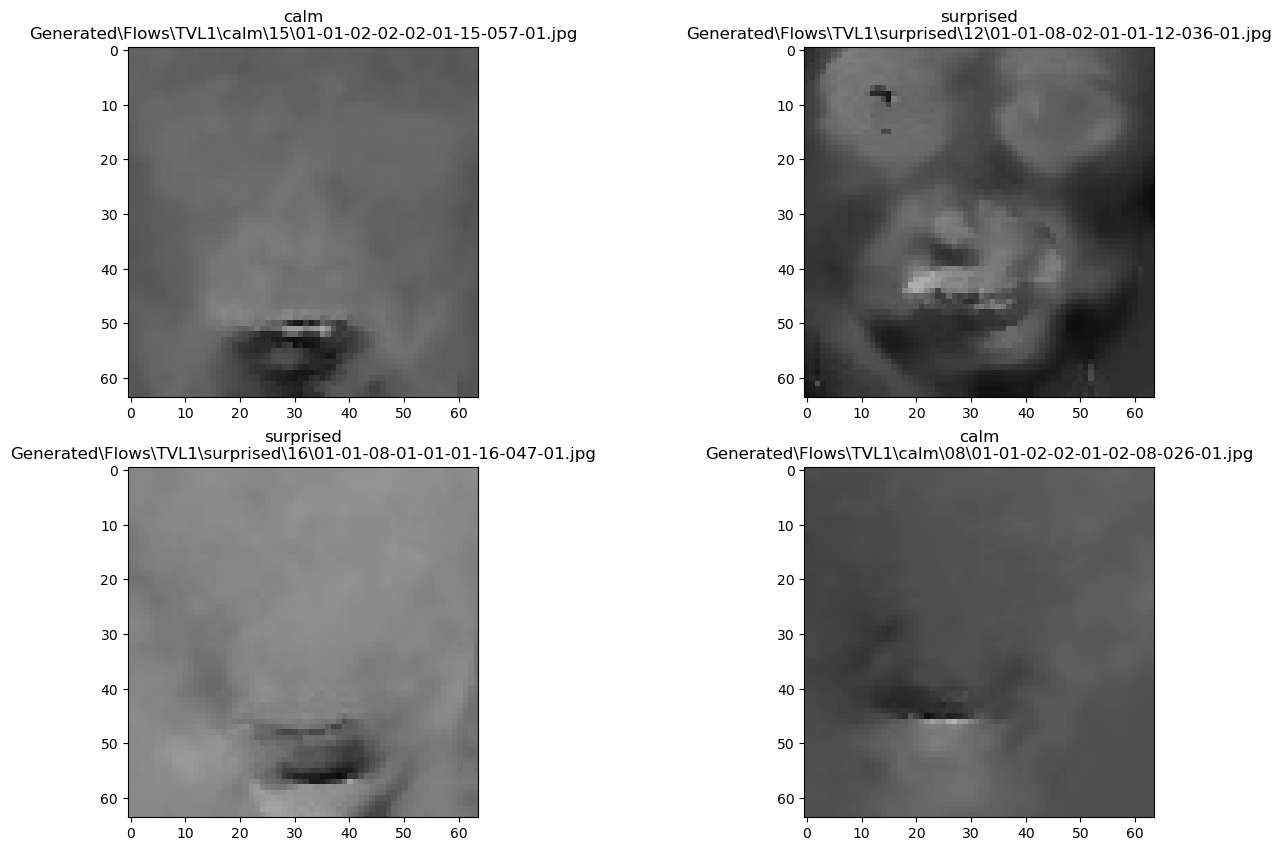

In [78]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 2
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    image = example_images[i]
    plt.imshow(image * 255, cmap='gray', vmin=0, vmax=255)

    plt.title(f'{label_names[example_labels[i]]}\n{train_files[i]}')

In [79]:
def create_cnn_model(name='baseline_model'):

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    conv1 = Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pool2)

    flatten = Flatten()(conv3)

    dense1 = Dense(128, activation='relu')(flatten)

    output = Dense(NUM_CLASSES, activation='softmax')(dense1)

    model = Model(inputs, output)

    model._name = name

    return model

In [80]:
tf.keras.backend.clear_session()  # clear all precedent models and sessions

In [81]:
model = create_cnn_model()
model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)    

In [82]:
# Define training callbacks

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    verbose=1,
    patience=5
)

In [83]:
METRICS = ['accuracy']

In [84]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        # learning_rate=0.0005
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

## Train Model

In [85]:
# TVL1
EPOCHS = 100
time_callback = TimeHistory()
history = model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[time_callback, early_stopping_callback]
)

Epoch 1/100
1049/1049 [==============================] - 829s 790ms/step - loss: 1.9610 - accuracy: 0.2179 - val_loss: 1.9619 - val_accuracy: 0.2389
Epoch 2/100
1049/1049 [==============================] - 203s 194ms/step - loss: 1.6815 - accuracy: 0.3693 - val_loss: 1.9278 - val_accuracy: 0.2762
Epoch 3/100
1049/1049 [==============================] - 203s 194ms/step - loss: 1.5006 - accuracy: 0.4472 - val_loss: 1.9776 - val_accuracy: 0.2700
Epoch 4/100
1049/1049 [==============================] - 203s 194ms/step - loss: 1.3563 - accuracy: 0.5066 - val_loss: 2.0513 - val_accuracy: 0.2767
Epoch 5/100
1049/1049 [==============================] - 203s 194ms/step - loss: 1.2478 - accuracy: 0.5487 - val_loss: 2.1305 - val_accuracy: 0.2688
Epoch 6/100
1049/1049 [==============================] - 203s 194ms/step - loss: 1.1585 - accuracy: 0.5834 - val_loss: 2.2042 - val_accuracy: 0.2715
Epoch 7/100
1049/1049 [==============================] - 203s 194ms/step - loss: 1.0793 - accuracy: 0.6137

In [86]:
print(time_callback.times)

[828.7819435596466, 203.08105754852295, 203.26770424842834, 203.17443466186523, 203.28362107276917, 203.09980130195618, 203.1918020248413]


In [87]:
EPOCHS = len(time_callback.times)

In [88]:
# Create model path
model_path = Path(const.models_path, 'Flow', model._name)
run_folders = list(Path(const.models_path, 'Flow', model._name).glob('Run_*'))

if not run_folders:
    model_path = Path(model_path, 'Run_1')
else:
    last_run = run_folders.pop()
    last_run_idx = Path(last_run).name.split('_')[-1]
    model_path = Path(model_path, f'Run_{int(last_run_idx) + 1}')

model_path.mkdir(parents=True, exist_ok=False)

In [89]:
# Save info on the indexes used for train, val and test
ds_info_path = Path(model_path, f'{model._name}_dataset.txt')
with open(ds_info_path, 'w+', newline='') as res_file:
    res_file.write(f'Train indexes: {train_idxs}\n')
    res_file.write(f'Train files: {train_ds_elements}\n')
    res_file.write(f'Val indexes: {val_idxs}\n')
    res_file.write(f'Val files: {val_ds_elements}\n')
    res_file.write(f'Test indexes: {test_idxs}\n')
    res_file.write(f'Test files: {test_ds_elements}\n')

In [91]:
metrics = history.history

In [92]:
metrics

{'loss': [1.9609919786453247,
  1.6815036535263062,
  1.5006479024887085,
  1.356296181678772,
  1.2477831840515137,
  1.1584657430648804,
  1.0792733430862427],
 'accuracy': [0.21788950264453888,
  0.369278222322464,
  0.4471629559993744,
  0.5065860152244568,
  0.5486500263214111,
  0.5833532214164734,
  0.6137352585792542],
 'val_loss': [1.9619297981262207,
  1.9278162717819214,
  1.9776489734649658,
  2.051271915435791,
  2.1305248737335205,
  2.2042152881622314,
  2.3221325874328613],
 'val_accuracy': [0.2389320731163025,
  0.27616313099861145,
  0.2700236439704895,
  0.2767263650894165,
  0.26884081959724426,
  0.27148813009262085,
  0.27385377883911133]}

In [93]:
mod_loss = metrics['loss']
mod_val_loss = metrics['val_loss']
mod_accuracy = metrics['accuracy']
mod_val_accuracy = metrics['val_accuracy']
# mod_f1 = metrics['fBeta_score']
# mod_val_f1 = metrics['val_fBeta_score']

mod_mean_loss = np.mean(mod_loss)
mod_mean_val_loss = np.mean(mod_val_loss)
mod_mean_accuracy = np.mean(mod_accuracy)
mod_mean_val_accuracy = np.mean(mod_val_accuracy)
# mod_mean_f1 = np.mean(mod_f1)
# mod_mean_val_f1 = np.mean(mod_val_f1)

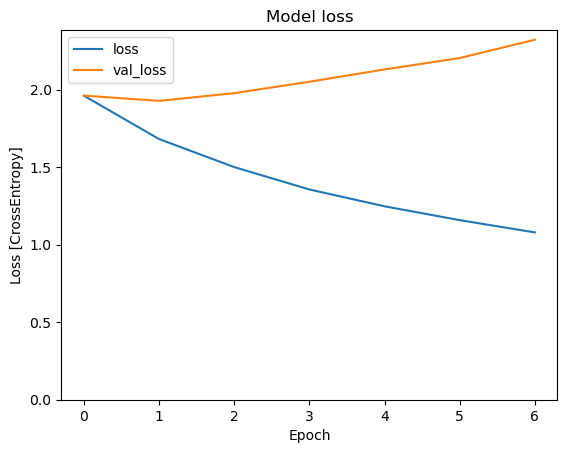

In [94]:
# Save Loss
plt.title('Model loss')
plt.plot(history.epoch, mod_loss, mod_val_loss)
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.savefig(Path(model_path, 'loss.png'))

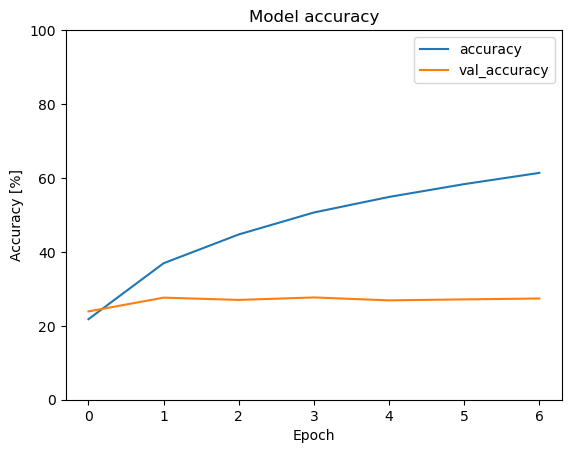

In [95]:
# Save Accuracy
plt.title('Model accuracy')
plt.plot(
    history.epoch, 100 * np.array(mod_accuracy),
    100 * np.array(mod_val_accuracy)
)
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.savefig(Path(model_path, 'accuracy.png'))


## Evaluate Model

In [96]:
model_eval = model.evaluate(test_ds, return_dict=True)

270/270 [==============================] - 18s 66ms/step - loss: 2.0325 - accuracy: 0.3421


In [97]:
# Save model
model.save(Path(model_path, f'{model._name}.keras'), overwrite=False)
# Save history
np.save(Path(model_path, f'{model._name}_history.npy'), history)
# Save model image
model_img_path = Path(model_path, f'{model._name}.png')
model_img = tf.keras.utils.plot_model(
    model, model_img_path, show_shapes=True, show_layer_names=True,
    show_layer_activations=True
)

INFO:tensorflow:Assets written to: ram://1c097aad-462b-4d67-953b-966e14bbe7ae/assets


In [98]:
test_loss = model_eval['loss']
test_accuracy = model_eval['accuracy']
# test_f1 = model_eval['fBeta_score']
mean_epoch_time = np.mean(time_callback.times)

In [99]:
train_ds_elements, test_ds_elements, val_ds_elements

(67112, 17236, 17754)

In [100]:
# Salvataggio informazioni modello
result_path = Path(model_path, f'{model._name}_result.txt')
with open(result_path, 'w+', newline='') as res_file:
    res_file.write(f'Dataset path: {dataset_path}\n')
    res_file.write(
        f'(train, val, test):\
        {train_ds_elements, test_ds_elements, val_ds_elements}\n'
    )
    res_file.write(f'Train loss: {str(mod_loss)}\n')
    res_file.write(f'val_loss: {str(mod_val_loss)}\n')
    res_file.write(f'Train accuracy: {str(mod_accuracy)}\n')
    res_file.write(f'Train val_accuracy: {str(mod_val_accuracy)}\n')
    # res_file.write(f'Train f1_score: {str(mod_f1)}\n')
    # res_file.write(f'Train val_f1_score: {str(mod_val_f1)}\n')
    res_file.write(f'Test loss: {str(test_loss)}\n')
    res_file.write(f'Test accuracy: {str(test_accuracy)}\n')
    # res_file.write(f'Test f1_score: {str(test_f1)}\n')
    res_file.write(f'Mean epoch time: {str(mean_epoch_time)}')

In [101]:
# Salvataggio informazioni generali modelli
with open(Path(const.models_path, 'Flow', 'models.csv'), 'a+') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=';', quotechar='|',
                            quoting=csv.QUOTE_MINIMAL)

    # filewriter.writerow(
    #     ["Model Name", "Epochs", "% Validation", "% Test set", "Train loss",
    #      "Train accuracy", "Val loss", "Val accuracy", "Test loss",
    #      "Test accuracy", "Mean epoch time", "Note"]
    # )

    test_ds_perc = utils.trunc((test_ds_elements * 100) / TOTAL_ELEMENTS, 2)
    val_ds_perc = utils.trunc((val_ds_elements * 100) / TOTAL_ELEMENTS, 2)
    full_path = str(Path(model._name, model_path.name))

    filewriter.writerow(
        [full_path, EPOCHS, val_ds_perc, test_ds_perc,
         mod_loss, mod_accuracy, mod_val_loss,
         mod_val_accuracy, test_loss, test_accuracy,
         mean_epoch_time, '']
    )

In [102]:
for test_images, test_labels in test_ds.take(1):
    print(test_images.shape)
    print(test_labels.shape)

(64, 64, 64, 1)
(64,)


Generated\Flows\TVL1\neutral\01\01-01-01-01-01-01-01-031-01.jpg


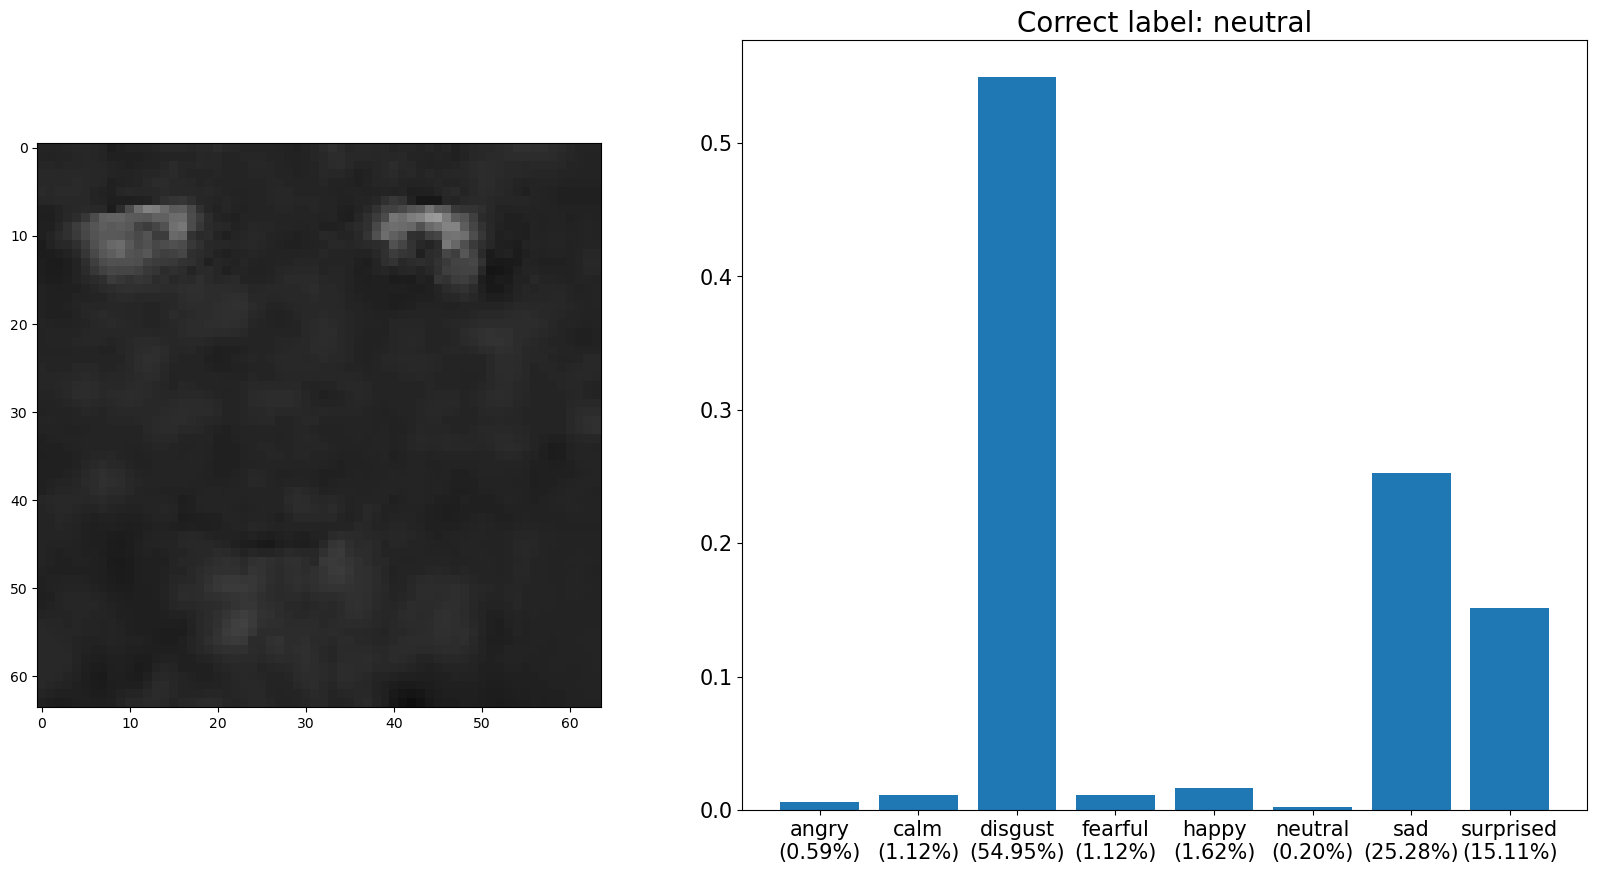

In [103]:
gen = np.random.default_rng(seed=None)
idx = gen.integers(0, len(test_images))
print(test_files[idx])

image = test_images[idx]
label = test_labels[idx]

net_input = utils.extend_tensor(image, 0)
prediction = model(net_input)
prediction = prediction[0].numpy()

valued_arr = []

for idx, name in enumerate(label_names):
    valued_arr.append(f'{name}\n({prediction[idx]:.2%})')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

pltDisplay(image * 255, ax=ax[0])


ax[1].bar(valued_arr, prediction)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {label_names[label]}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [104]:
y_pred = model.predict(test_ds)

270/270 [==============================] - 13s 47ms/step


In [105]:
y_pred = tf.argmax(y_pred, axis=1)

In [106]:
y_true = tf.concat(list(test_ds.map(lambda _, lab: lab)), axis=0)

In [107]:
report = classification_report(
    y_true, y_pred, target_names=label_names,
    output_dict=True, zero_division=np.nan
)

In [108]:
report_save_path = Path(model_path, f'{model._name}_report.txt')
with open(report_save_path, 'w+', newline='') as res_file:
    res_file.write(json.dumps(report))

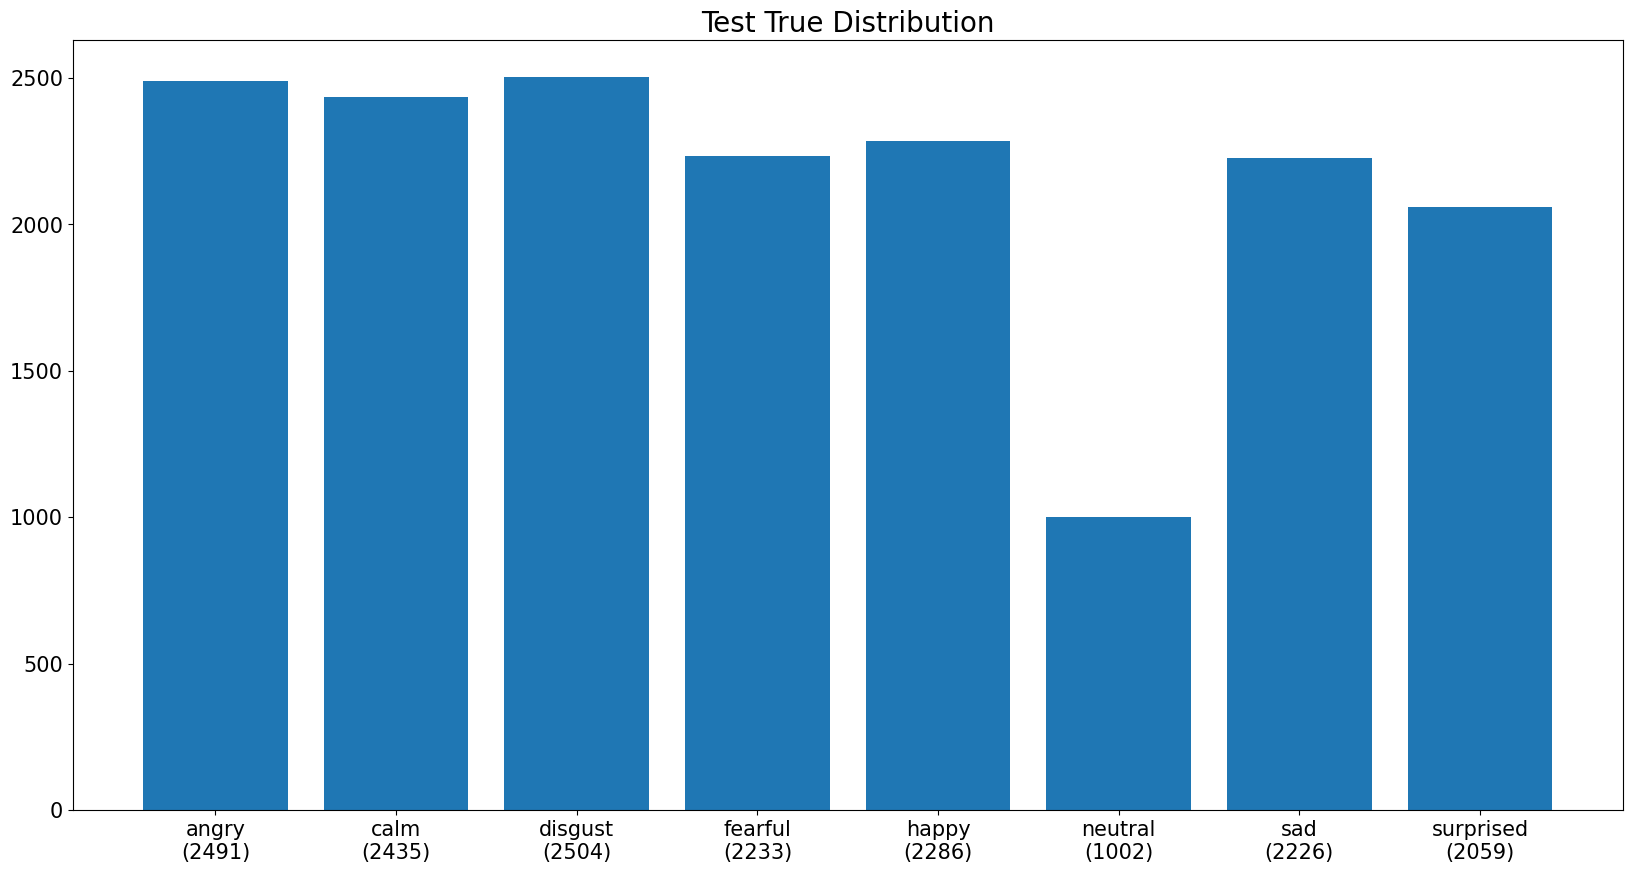

In [109]:
# True Test Distribution
# unique, counts = np.unique(y_true, return_counts=True)
# collections.Counter(y_true)

counts = [np.count_nonzero(y_true == idx) for idx in range(len(label_names))]
valued_arr = []
for i in range(len(label_names)):
    name = label_names[i]
    count = counts[i]
    valued_arr.append(f'{name}\n({count})')

fig = plt.subplots(figsize=(20, 10))
plt.bar(valued_arr, counts)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Test True Distribution', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.savefig(Path(model_path, f'{model._name}_trueDist.png'))
plt.show()

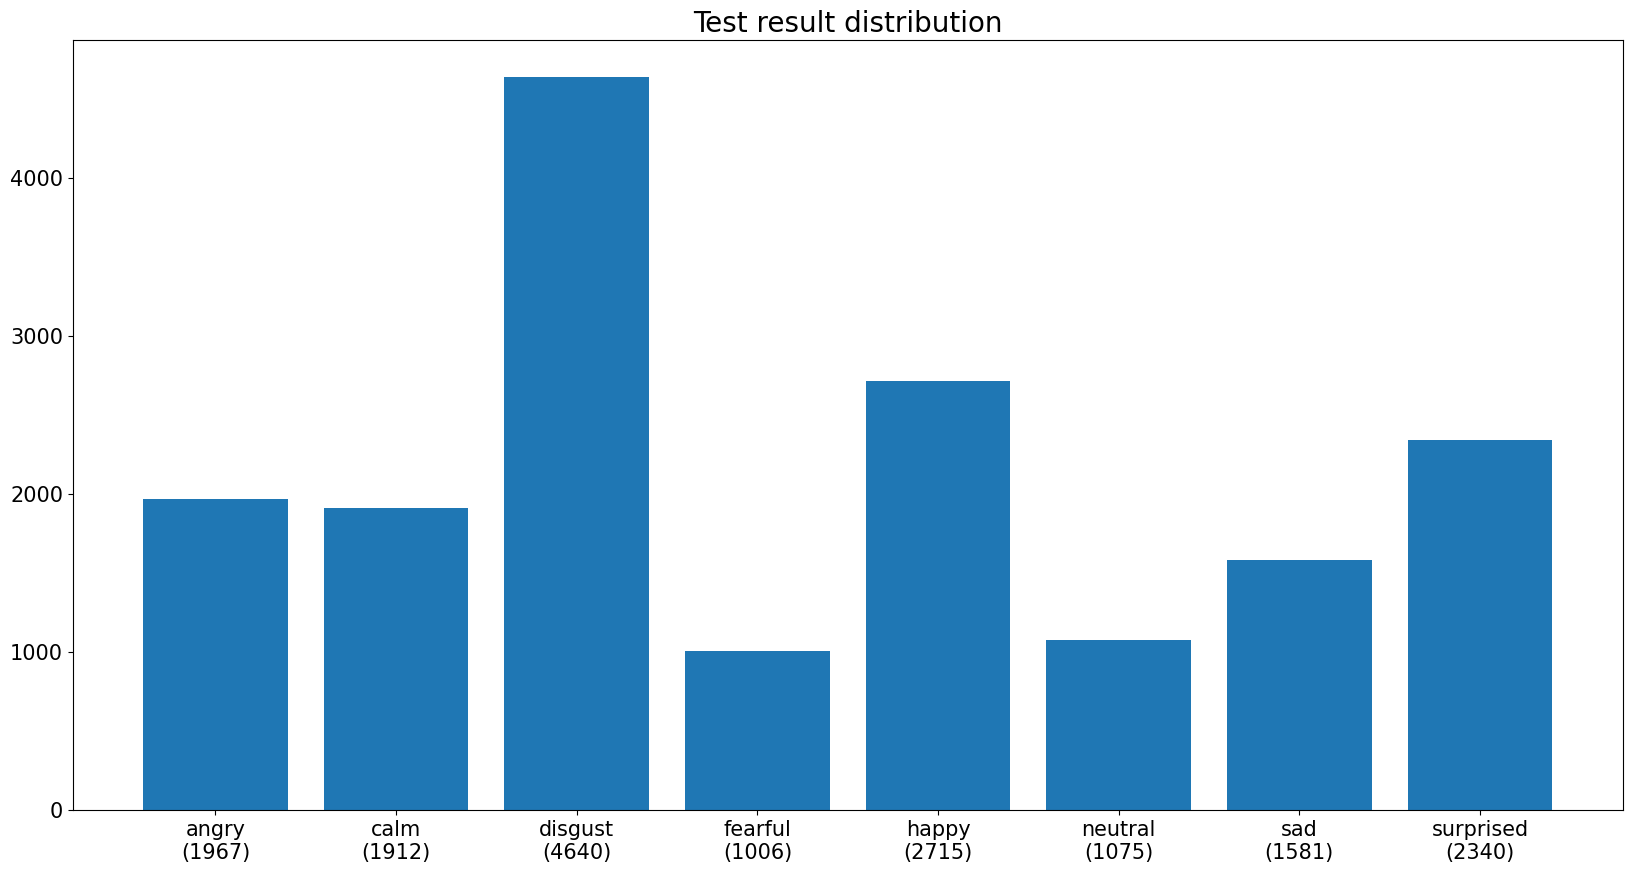

In [110]:
# Predicted Test Distribution
# unique, counts = np.unique(y_pred, return_counts=True)

counts = [np.count_nonzero(y_pred == idx) for idx in range(len(label_names))]
valued_arr = []
unique_idx = 0
for i in range(len(label_names)):
    name = label_names[i]
    count = counts[i]
    valued_arr.append(f'{name}\n({count})')

fig = plt.subplots(figsize=(20, 10))
plt.bar(valued_arr, counts)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Test result distribution', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.savefig(Path(model_path, f'{model._name}_predDist.png'))
plt.show()

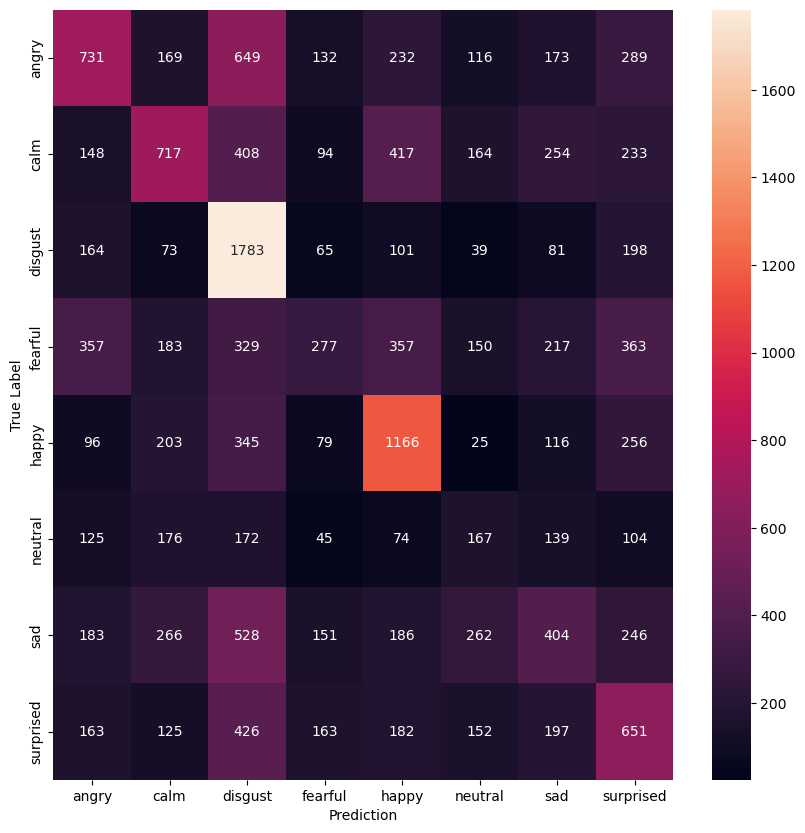

In [111]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='.6g')
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.savefig(Path(model_path, f'{model._name}_heat.png'))
plt.show()

## Run inference on an image file

Finally, verify the model's prediction output using an image

Generated\Flows\TVL1\neutral\01\01-01-01-01-01-01-01-020-01.jpg


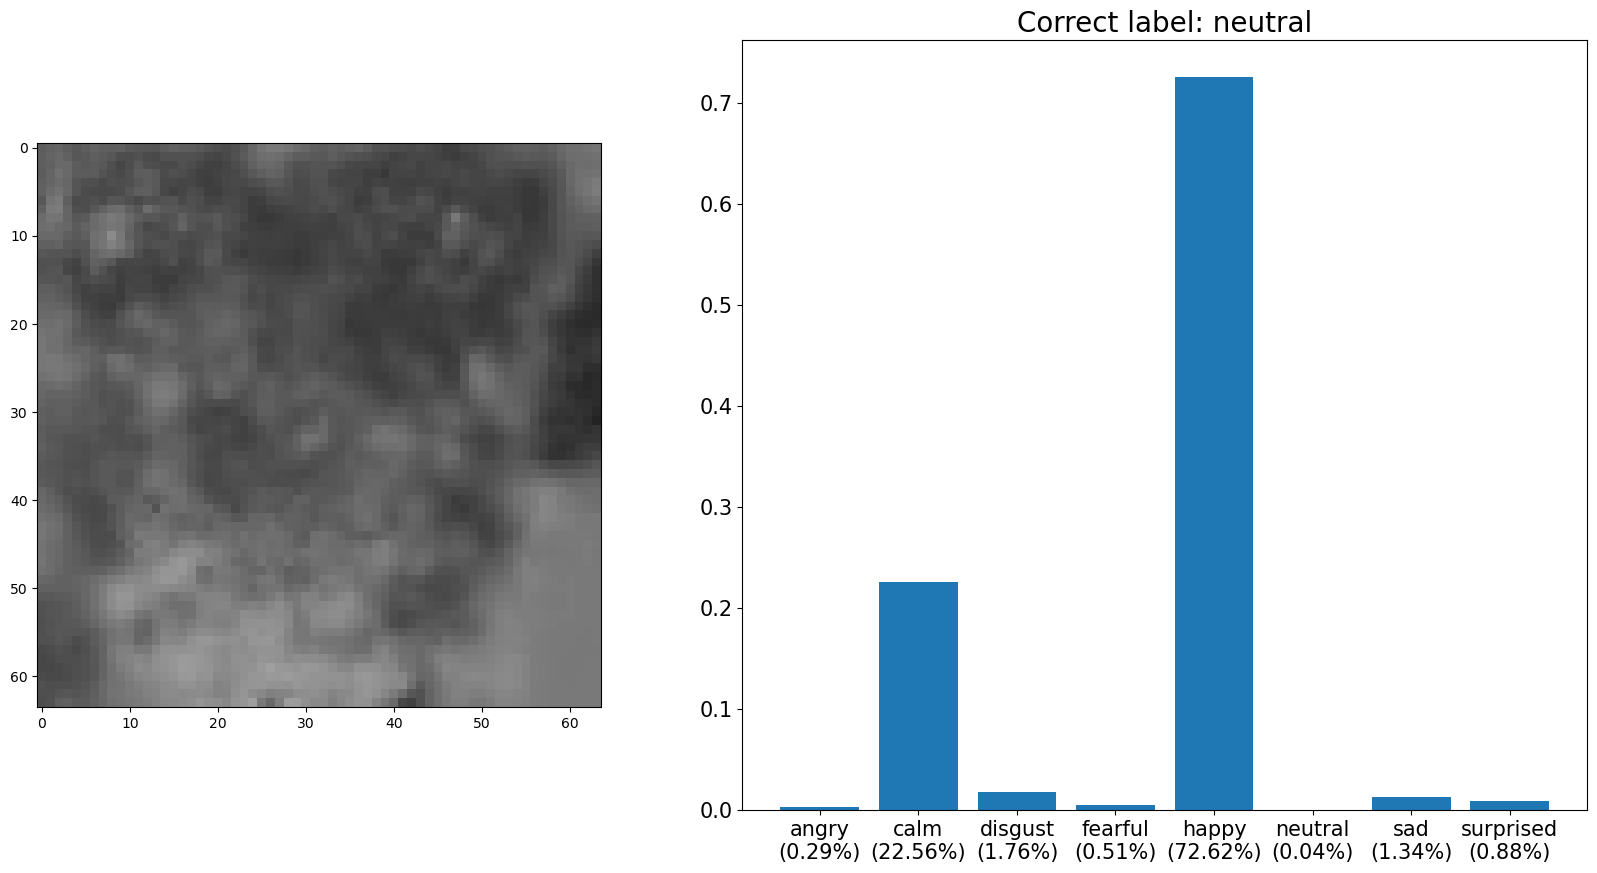

In [112]:
# Take the first item of each class in test_files
# path = Path(next((subs for subs in test_files if 'angry' in subs), None))
# path = Path(next((subs for subs in test_files if 'calm' in subs), None))
# path = Path(next((subs for subs in test_files if 'disgust' in subs), None))
# path = Path(next((subs for subs in test_files if 'fearful' in subs), None))
# path = Path(next((subs for subs in test_files if 'happy' in subs), None))
path = Path(next((subs for subs in test_files if 'neutral' in subs), None))
# path = Path(next((subs for subs in test_files if 'sad' in subs), None))
# path = Path(next((subs for subs in test_files if 'surprised' in subs), None))

print(path)
# print(tf.io.read_file(str(path)))
label = path.parent.parent.name


image = cv2.imread(str(path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
image = image / 255

net_input = utils.extend_tensor(image, 0)
prediction = model(net_input)
prediction = prediction[0].numpy()

valued_arr = []

for idx, name in enumerate(label_names):
    valued_arr.append(f'{name}\n({prediction[idx]:.2%})')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

pltDisplay(image * 255, ax=ax[0])


ax[1].bar(valued_arr, prediction)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {label}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [113]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Accept either a string-filename or a batch of waveforms.
        # Could add additional signatures for a single wave, or a ragged-batch.
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(
                shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS],
                dtype=tf.float32
            )
        )

    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it.

        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            print(x)
            x = tf.io.decode_jpeg(x, channels=1, fancy_upscaling=False)
            # x = cv2.imread(str(x))
            print(x)
            # x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            print(x)
            # x = cv2.resize(x, (IMG_HEIGHT, IMG_WIDTH))
            x = tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH))
            print(x)
            x = x / 255
            print(x)
            x = utils.extend_tensor(x, 0)
            print(x)

        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions': result,
                'class_ids': class_ids,
                'class_names': class_names}

Test run the "export" model:

In [114]:
export = ExportModel(model)
img_path = next(dataset_path.rglob('*-01.jpg'))

export_res = export(tf.constant(str(img_path)))

Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("DecodeJpeg:0", shape=(None, None, 1), dtype=uint8)
Tensor("DecodeJpeg:0", shape=(None, None, 1), dtype=uint8)
Tensor("resize/Squeeze:0", shape=(64, 64, 1), dtype=float32)
Tensor("truediv:0", shape=(64, 64, 1), dtype=float32)
Tensor("ExpandDims:0", shape=(1, 64, 64, 1), dtype=float32)


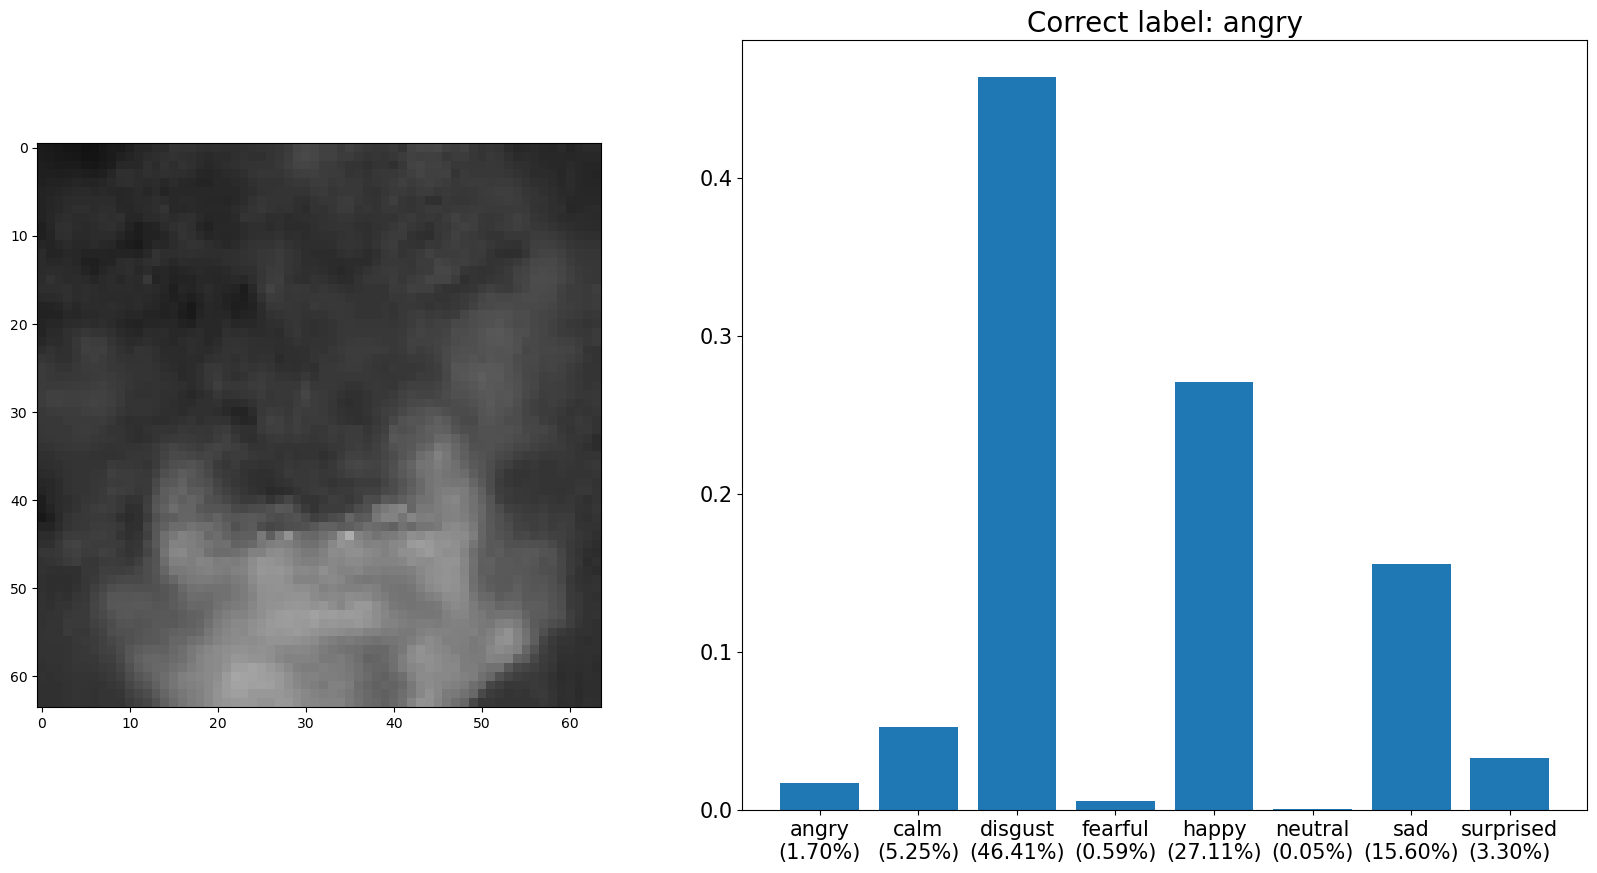

In [115]:
prediction = export_res['predictions'][0].numpy()

valued_arr = []

for idx, name in enumerate(label_names):
    valued_arr.append(f'{name}\n({prediction[idx]:.2%})')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

image = cv2.imread(str(img_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
pltDisplay(image, ax=ax[0])


ax[1].bar(valued_arr, prediction)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {str(Path(img_path).parent.parent.name)}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

In [116]:
E2E_model_path = Path(model_path, 'E2E/')
tf.saved_model.save(export, E2E_model_path)
imported = tf.saved_model.load(E2E_model_path)

imported_res = imported(tf.constant(str(img_path)))

Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("DecodeJpeg:0", shape=(None, None, 1), dtype=uint8)
Tensor("DecodeJpeg:0", shape=(None, None, 1), dtype=uint8)
Tensor("resize/Squeeze:0", shape=(64, 64, 1), dtype=float32)
Tensor("truediv:0", shape=(64, 64, 1), dtype=float32)
Tensor("ExpandDims:0", shape=(1, 64, 64, 1), dtype=float32)
INFO:tensorflow:Assets written to: Models\Flow\baseline_model\Run_3\E2E\assets


In [117]:
np.array_equal(export_res['predictions'].numpy(), imported_res['predictions'].numpy())

True

---

Useful Sources
- https://www.youtube.com/watch?v=5AUypv5BNbI (Optic Flow Problem)
- https://www.youtube.com/watch?v=4v_keMNROv4 (Optic Flow Solution)
- https://www.youtube.com/watch?v=BMFYHfwHm0g (TO WATCH - Flow Method Comparison)